In [1]:
import os
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import dropwhile
from scipy.optimize import curve_fit

ecdc_path = '../Datasets/DLL/ECDC/DLL_COVID_TRAIN.csv'

data = pd.read_csv(ecdc_path, parse_dates=['dateRep'])
data['dates'] = data['dateRep'].dt.date
# data.head()

country_keys = list(set(data['countryterritoryCode']))

country_data = {}
for key in country_keys:
    d = data[data.countryterritoryCode==key]
    country_data[key] = d


In [2]:
def f(t, a, b, c):
    return np.exp(a-(a-b)*np.exp(-c*t))

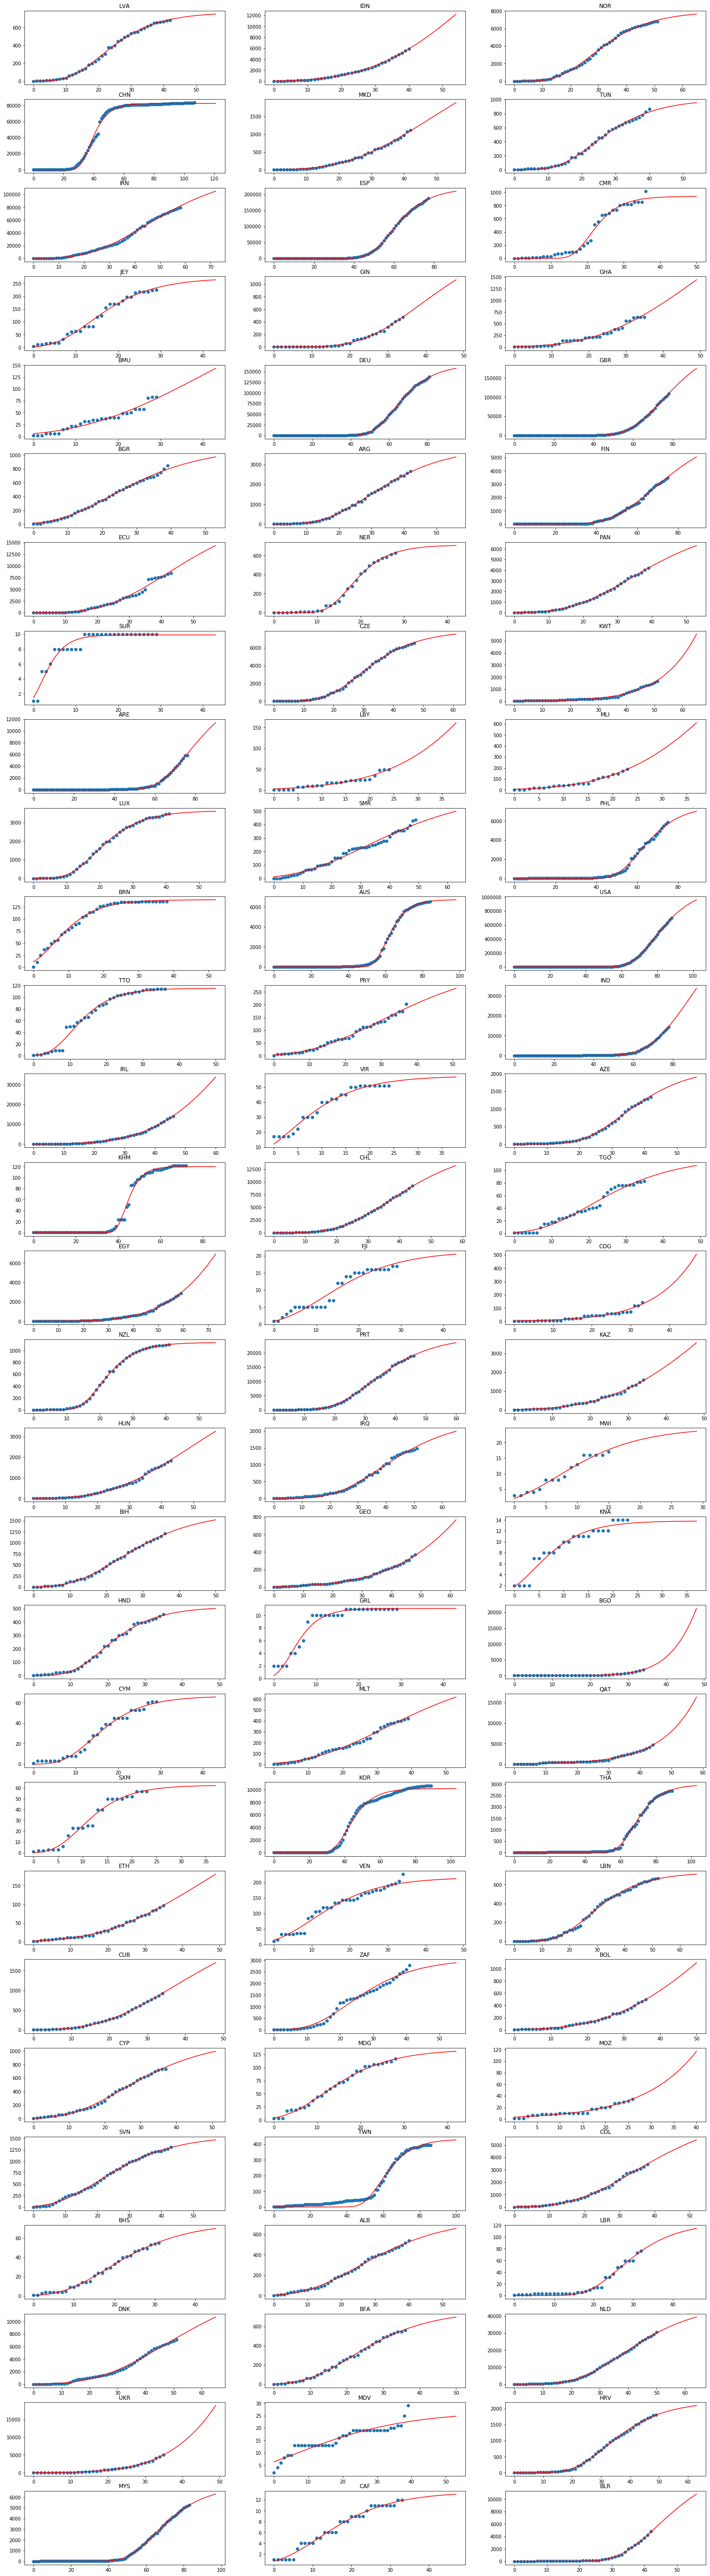

<Figure size 432x288 with 0 Axes>

In [13]:
fig, axs = plt.subplots(29, 3, figsize=(26, 100))
axs = axs.flatten()
conv = []
no_conv = []
i = 0

output_fitted = {}

for key in country_keys:
    country = country_data[key]
    dates = list(country['dates'])
    cases = list(country['cases'])
    deaths = list(country['deaths'])
    dates.reverse()
    cases.reverse()
    # deaths.reverse()
    dates = np.array(dates)
    cum_cases = np.array(cases).cumsum()
    cum_deaths = np.array(deaths).cumsum()

    cum_cases = list(dropwhile(lambda x: x==0, cum_cases))
    new_dates = dates[-len(cum_cases):]
    cum_deaths = cum_deaths[-len(cum_cases):]
    
    if key == 'CHN':
        new_dates = new_dates[:-2]
        cum_cases = cum_cases[:-2]
        cum_deaths = cum_deaths[:-2]
        
    x = np.array(range(len(new_dates)))
    y = np.array(cum_cases)
    if max(y) < 10:
        no_conv.append(key)
        continue
        
    try:
        popt, pcov = curve_fit(f, x, y)  # fit krivulje na podacima od start do start+50
        conv.append(key)
        test = np.arange(len(x)+14)
        if i < 87:
            axs[i].scatter(x, y)
            axs[i].plot(test, f(test, *popt), 'r-')
            axs[i].set_title(key)
        i += 1
        
        x_predict = list(test[-14:])
        y_predict = [f(x, *popt) for x in x_predict]
        out = np.round(np.array([cum_cases[-1]] + y_predict))
        out = np.array(np.diff(out), dtype=int)
        output_fitted[key] = np.array([x if x>0 else 0 for x in out])
        
    except RuntimeError:
        #print("No convergence for: ", key)
        no_conv.append(key)
        continue

plt.show()
plt.savefig('cases_predicts.png')

27


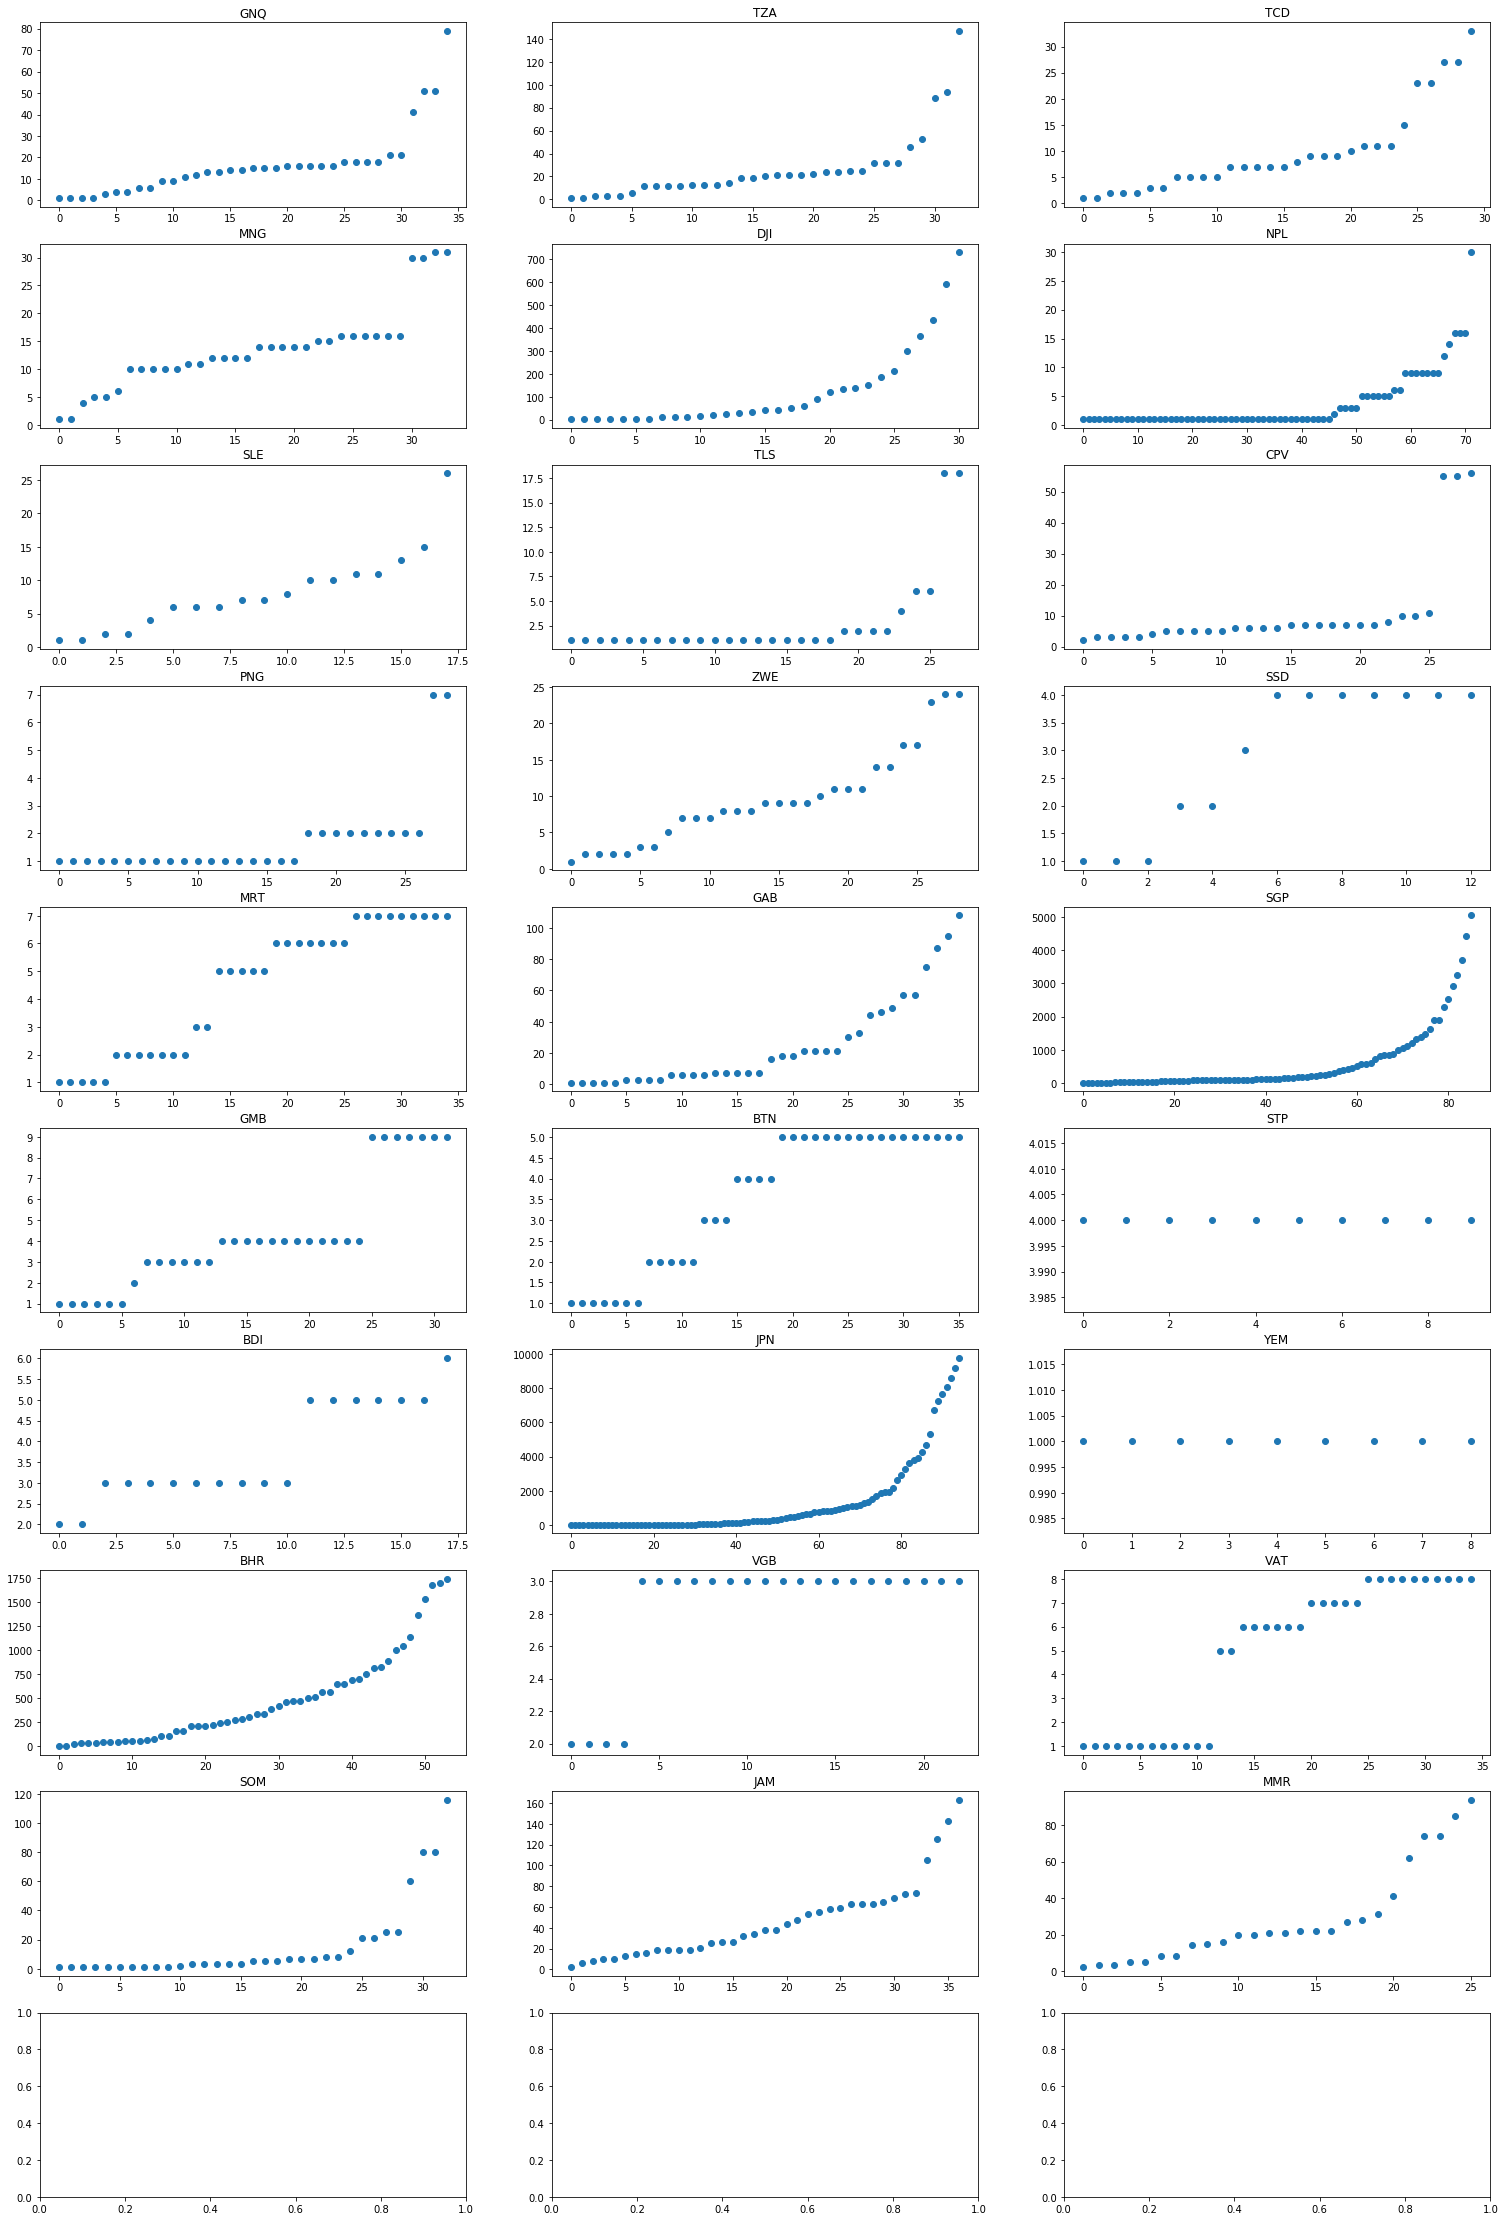

<Figure size 432x288 with 0 Axes>

In [14]:
fig, axs = plt.subplots(10, 3, figsize=(26, 40))
axs = axs.flatten()

output_zeros = {}
keys_left = []

print(len(no_conv))

for i, key in enumerate(no_conv):
    country = country_data[key]
    dates = list(country['dates'])
    cases = list(country['cases'])
    deaths = list(country['deaths'])
    dates.reverse()
    cases.reverse()
    deaths.reverse()
    dates = np.array(dates)
    cum_cases = np.array(cases).cumsum()
    cum_deaths = np.array(deaths).cumsum()
    
    cum_cases = list(dropwhile(lambda x: x==0, cum_cases))
    new_dates = dates[-len(cum_cases):]
    cum_deaths = cum_deaths[-len(cum_cases):]
    
    x = np.array(range(len(new_dates)))
    y = np.array(cum_cases)
    
    if np.max(y) <= 10:
        output_zeros[key] = np.array([0 for _ in range(14)], dtype=int)
    else:
        keys_left.append(key)
    
    if i < 87:
        axs[i].scatter(x, y)
        axs[i].set_title(key)
    
plt.show()
plt.savefig('not_fitted_cases.png')

In [15]:
print(keys_left)

['GNQ', 'TZA', 'TCD', 'MNG', 'DJI', 'NPL', 'SLE', 'TLS', 'CPV', 'ZWE', 'GAB', 'SGP', 'JPN', 'BHR', 'SOM', 'JAM', 'MMR']


['GNQ', 'TZA', 'TCD', 'MNG', 'DJI', 'NPL', 'SLE', 'TLS', 'CPV', 'ZWE', 'GAB', 'SGP', 'JPN', 'BHR', 'SOM', 'JAM', 'MMR']
GNQ
[ 2  0  0  0  3  0 20 10  0 28]
13
TZA
[ 1  0  7  0  0 14  7 35  6 53]
25
TCD
[1 1 0 0 4 8 0 4 0 6]
5
MNG
[ 1  0  0  0  0  0 14  0  1  0]
3
DJI
[ 14   5  10  37  27  84  65  72 156 141]
125
NPL
[ 0  0  0  0  3  2  2  0  0 14]
4
SLE
[ 1  0  1  2  0  1  0  2  2 11]
4
TLS
[ 0  1  0  0  0  2  2  0 12  0]
3
CPV
[ 0  0  0  1  2  0  1 44  0  1]
10
ZWE
[1 0 0 3 0 3 0 6 1 0]
3
GAB
[ 3 11  2  3  8  0 18 12  8 13]
13
SGP
[142 286   0 390 233 386 334 447 728 623]
673
JPN
[ 351  410  680 1401  507  390  455  482  585  628]
953
BHR
[ 12  64 111  42  96 225 167 145  27  44]
160
SOM
[ 0  4  9  0  4  0 35 20  0 36]
20
JAM
[ 0  0  2  4  3  1 32 20 18 20]
21
MMR
[ 0  5  1  3 10 21 12  0 11  9]
14


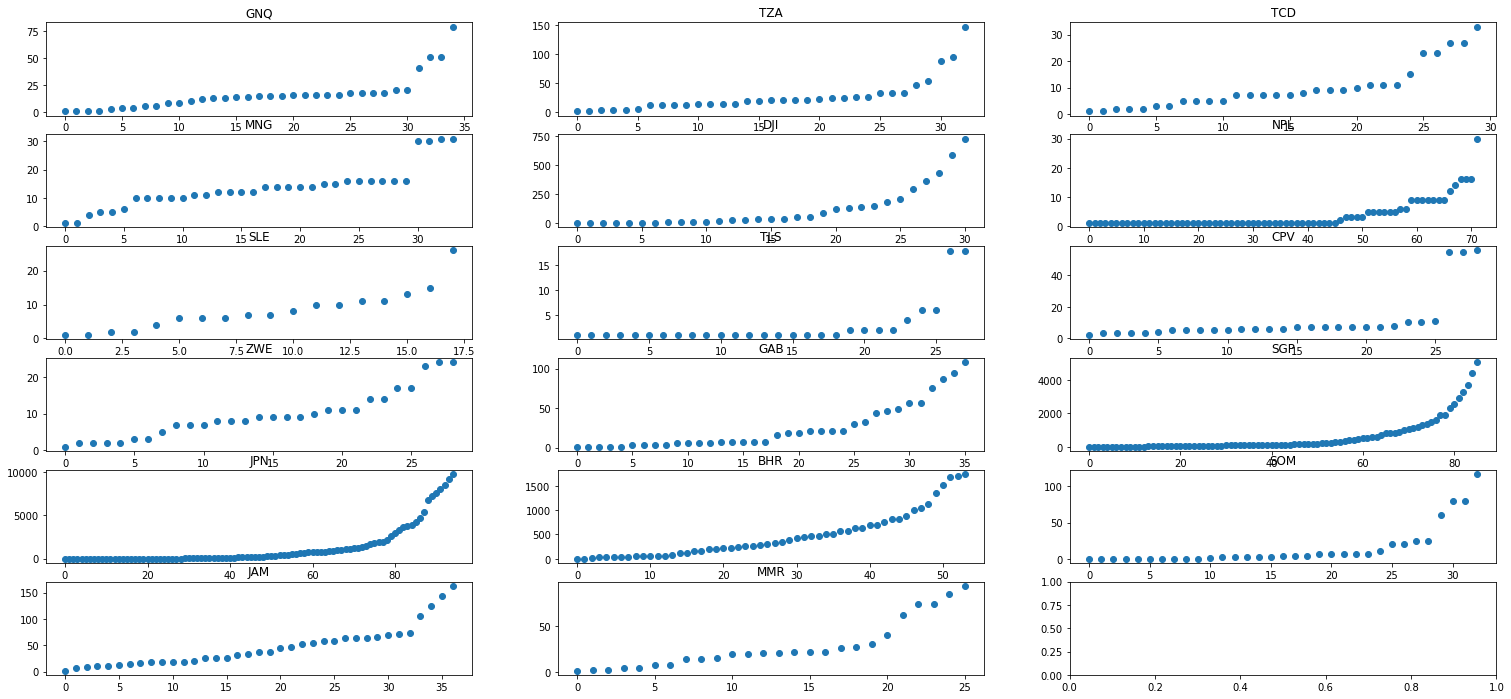

In [18]:
fig, axs = plt.subplots(6, 3, figsize=(26, 12))
axs = axs.flatten()

print(keys_left)

output_manual = {}

for i, key in enumerate(keys_left):
    country = country_data[key]
    dates = list(country['dates'])
    cases = list(country['cases'])
    deaths = list(country['deaths'])
    dates.reverse()
    cases.reverse()
    deaths.reverse()
    dates = np.array(dates)
    cum_cases = np.array(cases).cumsum()
    cum_deaths = np.array(deaths).cumsum()
    
    cum_cases = list(dropwhile(lambda x: x==0, cum_cases))
    new_dates = dates[-len(cum_cases):]
    cum_deaths = cum_deaths[-len(cum_cases):]
    
    cases = np.array(cases[-len(cum_cases):])
    
    x = np.array(range(len(new_dates)))
    y = np.array(cum_cases)
    
    print(key)
    print(cases[-10:])
    
    val = int(np.round(np.mean(cases[-7:])*1.5))
    print(val)
    
    output_manual[key] = np.array([val for _ in range(14)])
    
    axs[i].scatter(x, y)
    axs[i].set_title(key)
    
plt.show()

In [19]:
cases_output = {}
dates_output = np.array(['2020-04-19', '2020-04-20', '2020-04-21', '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
                         '2020-04-26', '2020-04-27', '2020-04-28', '2020-04-29', '2020-04-30', '2020-05-01', '2020-05-02'])

for k, v in output_fitted.items():
    cases_output[k] = v
for k, v in output_manual.items():
    cases_output[k] = v
for k, v in output_zeros.items():
    cases_output[k] = v
    
with open('cases.csv', 'w') as f:
    f.write('Country,Date,Cases\n')
    for key, values in cases_output.items():
        for date, value in zip(dates_output, values):
            f.write(key+','+str(date)+','+str(value)+'\n')

In [24]:
cases_path = 'cases.csv'
deaths_path = 'deaths.csv'

In [25]:
f1 = open(cases_path)
f2 = open(deaths_path)

cases = f1.readlines()
deaths = f2.readline()

f1.close()
f2.close()

In [27]:
cases

['Country,Date,Cases\n',
 'LVA,2020-04-19,13\n',
 'LVA,2020-04-20,7\n',
 'LVA,2020-04-21,6\n',
 'LVA,2020-04-22,6\n',
 'LVA,2020-04-23,5\n',
 'LVA,2020-04-24,5\n',
 'LVA,2020-04-25,4\n',
 'LVA,2020-04-26,4\n',
 'LVA,2020-04-27,4\n',
 'LVA,2020-04-28,3\n',
 'LVA,2020-04-29,3\n',
 'LVA,2020-04-30,2\n',
 'LVA,2020-05-01,2\n',
 'LVA,2020-05-02,3\n',
 'IDN,2020-04-19,340\n',
 'IDN,2020-04-20,394\n',
 'IDN,2020-04-21,406\n',
 'IDN,2020-04-22,419\n',
 'IDN,2020-04-23,430\n',
 'IDN,2020-04-24,442\n',
 'IDN,2020-04-25,453\n',
 'IDN,2020-04-26,463\n',
 'IDN,2020-04-27,474\n',
 'IDN,2020-04-28,483\n',
 'IDN,2020-04-29,493\n',
 'IDN,2020-04-30,501\n',
 'IDN,2020-05-01,509\n',
 'IDN,2020-05-02,517\n',
 'NOR,2020-04-19,228\n',
 'NOR,2020-04-20,73\n',
 'NOR,2020-04-21,67\n',
 'NOR,2020-04-22,63\n',
 'NOR,2020-04-23,58\n',
 'NOR,2020-04-24,54\n',
 'NOR,2020-04-25,49\n',
 'NOR,2020-04-26,46\n',
 'NOR,2020-04-27,43\n',
 'NOR,2020-04-28,40\n',
 'NOR,2020-04-29,36\n',
 'NOR,2020-04-30,34\n',
 'NOR,2020-05